In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# generate some data
mu_0 = -6
sigma_0 = 3
mu_1 = 3
sigma_1 = 2

n_clips = 2000
n_pos = 500

# generate data
scores = np.zeros(n_clips)
labels = np.zeros(n_clips)
scores[:n_pos] = np.random.normal(mu_1, sigma_1, n_pos)
labels[:n_pos] = 1
scores[n_pos:] = np.random.normal(mu_0, sigma_0, n_clips - n_pos)
labels[n_pos:] = 0

# make a labeling weighting. Try 1/rank
df = pd.DataFrame({'score': scores, 'label': labels})
df = df.sort_values("score", ascending=False)
#df["weighting"] = 1/(1 + np.arange(len(df)))
df["weighting"] = 1
# shuffle them just to remove any ordering
df = df.sample(frac=1)

# ensure labels are integers
df["label"] = df["label"].astype(int)

n_labeled = 50

# sample according to the weighting
labeled = df.sample(n_labeled, weights="weighting")
unlabeled = df.drop(labeled.index)

# normalize the labeled weights
labeled["weighting"] = labeled["weighting"] / labeled["weighting"].sum()

# make the data dictionary
data = {'N_labeled': len(labeled), 
        'N_unlabeled': len(unlabeled), 
        'scores_labeled': labeled['score'].values, 
        'scores_unlabeled': unlabeled['score'].values,
        'sampling_weight': labeled["weighting"].values,
        'labels': labeled["label"].values}

# make the data


Number of positives in labeled data: 14
proportion of positives in labeled data: 0.28
proportion of positives in all data: 0.25


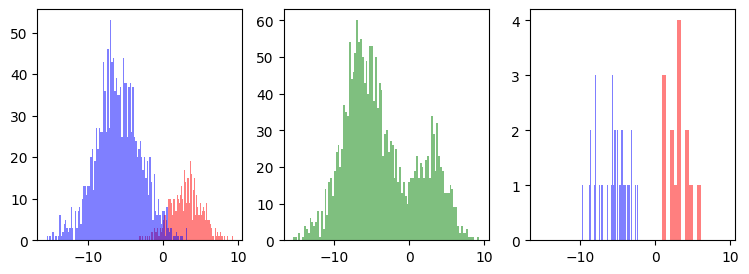

In [97]:
# plot the histogram of scores
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True)
pos = df[df['label'] == 1]
neg = df[df['label'] == 0]
ax[0].hist(pos['score'], bins=100, alpha=0.5, label='pos', color='red')
ax[0].hist(neg['score'], bins=100, alpha=0.5, label='neg', color='blue')
ax[1].hist(df['score'], bins=100, alpha=0.5, label='all', color='green')
ax[2].hist(labeled[labeled["label"] ==1]['score'], bins=10, alpha=0.5, label='labeled', color='red')
ax[2].hist(labeled[labeled["label"] ==0]['score'], bins=50, alpha=0.5, label='unlabeled', color='blue')
print(f"Number of positives in labeled data: {np.sum(labeled['label'])}")
print(f"proportion of positives in labeled data: {np.mean(labeled['label'])}")
print(f"proportion of positives in all data: {np.mean(df['label'])}")

In [4]:
#import cmdstanpy and use the stan model
import cmdstanpy
file = "weighted_sample_gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

In [342]:
# fit the model
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=250)

10:19:44 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:19:46 - cmdstanpy - INFO - CmdStan done processing.
10:19:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'weighted_sample_gmm.stan', line 29, column 12 to line 31, column 86)
Consider re-running with show_console=True if the above output is unclear!


In [343]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-9127.850000,0.064205,1.537880,-9130.990000,-9127.540000,-9125.980000,573.722000,162.804000,0.996700
mu[1],-5.858770,0.002857,0.071888,-5.970820,-5.860980,-5.733930,633.199000,179.682000,1.004650
mu[2],2.987570,0.001490,0.050467,2.904700,2.987590,3.072200,1147.510000,325.627000,0.998186
sigma[1],2.674740,0.002195,0.055752,2.583970,2.672660,2.770920,645.413000,183.148000,1.004820
sigma[2],1.716550,0.001156,0.035527,1.660070,1.716800,1.777460,944.654000,268.063000,0.998599
theta,0.447493,0.000364,0.009260,0.432378,0.447506,0.462609,645.829078,183.265913,1.006714
n_pos_pred,978.294000,0.379389,10.419219,960.000000,979.000000,995.000000,754.223709,214.024889,1.007329


In [321]:
# now compare it to regular gmm model
file = "gmm.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)
fit = model.sample(data=data, chains=4, iter_warmup=250, iter_sampling=500)
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()

09:10:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

09:10:46 - cmdstanpy - INFO - CmdStan done processing.
09:10:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter is inf, but must be finite! (in 'gmm.stan', line 27, column 12 to line 29, column 86)
Consider re-running with show_console=True if the above output is unclear!


In [322]:
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-5038.44000,0.059677,1.567020,-5041.49000,-5038.11000,-5036.55000,689.51100,35.23840,1.000760
mu[1],-6.07825,0.002501,0.076809,-6.20668,-6.07822,-5.95779,943.26100,48.20670,1.005860
mu[2],1.11846,0.097644,2.120370,-2.66295,1.35462,4.04963,471.54900,24.09920,1.004910
sigma[1],2.86543,0.001630,0.053246,2.77757,2.86546,2.95166,1066.91000,54.52570,0.999814
sigma[2],3.16881,0.046879,1.045640,1.57590,3.13416,4.95422,497.51600,25.42630,1.001260
theta,0.02074,0.000590,0.014340,0.00657,0.01607,0.04996,596.14382,30.46680,1.007000
n_pos_pred,40.54300,1.170520,28.104860,15.00000,31.00000,100.00000,576.50374,29.46306,1.007480


In [100]:
# try with the GP model
#import cmdstanpy and use the stan model
file = "GP.stan"
model = cmdstanpy.CmdStanModel(stan_file=file)

17:51:59 - cmdstanpy - INFO - compiling stan file /Users/LOF19/Dev/stan_models/GP.stan to exe file /Users/LOF19/Dev/stan_models/GP
17:52:17 - cmdstanpy - INFO - compiled model executable: /Users/LOF19/Dev/stan_models/GP


In [101]:
# subset the data so we can fit the gp
data_gp = data.copy()

# fit the model
fit = model.sample(data=data_gp, chains=1, iter_warmup=500, iter_sampling=500, show_console=True)

17:52:17 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 500
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 10 (Default)
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /var/folders/_s/zm3gz4x52glfbflc25_3rp3w0000gq/T/tmp7jpcz05_/qzmsvcon.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [

17:52:33 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 7.617 seconds (Warm-up)
Chain [1] 8.085 seconds (Sampling)
Chain [1] 15.702 seconds (Total)
Chain [1] 
Chain [1] 


In [102]:
samples = fit.draws_pd()
# summarize the results
summary = fit.summary()
summary

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-100.207000,0.798149,10.150000,-119.056000,-99.209100,-84.62700,161.720000,20.002500,1.003930
rho,2.327330,0.068515,1.475450,0.329897,2.130520,5.23057,463.748000,57.359100,0.998016
eta[1],0.540284,0.028086,0.873015,-0.928490,0.524053,2.06534,966.211000,119.507000,0.998594
eta[2],-0.307764,0.022086,0.811329,-1.654750,-0.303753,1.05634,1349.490000,166.912000,0.998003
eta[3],-0.030123,0.028523,0.944532,-1.601630,-0.019253,1.54106,1096.600000,135.634000,0.999446
...,...,...,...,...,...,...,...,...,...
f[197],8.940150,0.038189,0.952630,7.225590,8.958310,10.53190,622.275000,76.966600,0.999459
f[198],9.087690,0.036383,0.959435,7.351650,9.093490,10.66010,695.415000,86.013000,0.998659
f[199],9.230630,0.039460,0.972269,7.524520,9.261430,10.78280,607.110000,75.090900,0.999487
f[200],9.390840,0.038420,0.979824,7.769380,9.413670,10.94190,650.389000,80.443900,0.999965


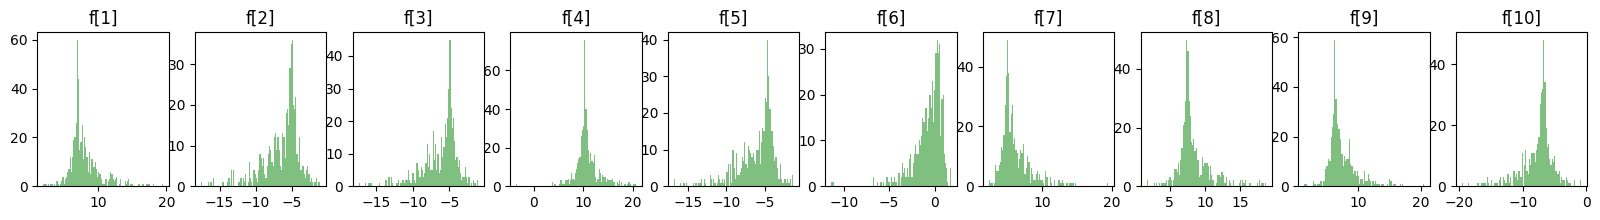

In [66]:
# plot histograms of f[1], f[11], f[21], f[31], f[41], f[51], f[61], f[71], f[81], f[91]
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].hist(samples[f"f[{i+1}]"], bins=100, alpha=0.5, label=f"f[{i+1}]", color='green')
    ax[i].set_title(f"f[{i+1}]")